In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve,auc,classification_report,confusion_matrix,plot_roc_curve
from sklearn.neighbors  import KNeighborsClassifier 
from sklearn.model_selection import KFold,cross_val_score,train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from imblearn.over_sampling import SMOTE

In [2]:
#import dataset and declare dependent and independent variables
remove=[0,16,-1]
df=pd.read_csv("FICO_excellent.csv")
df.drop(df.columns[remove],axis=1,inplace=True)
y=df["status_time"].values

In [3]:
#Set possible K values for KNN
knn_n=[1,3,5,7,9,11,13,15]

In [4]:
newdf = pd.DataFrame(scale(df), index=df.index, columns=df.columns)
newdf=newdf.round(3)

In [5]:
df=newdf


In [6]:
x=df.drop("status_time", axis=1).values

In [7]:
train_x, test_x, train_y, test_y=train_test_split(x, y, train_size=0.8,random_state=0)
SMOTE=SMOTE(random_state=0)
S_train_x, S_train_y=SMOTE.fit_sample(train_x, train_y)

In [103]:
train_x.shape

(4052, 32)

In [8]:
#Set K-Fold cross-validation (K=5)
kf=KFold(n_splits=5,random_state=2,shuffle=True)

In [9]:
#Using iteration to find the best F-Score with the best K in KNN
best_k=knn_n[0]
best_score=0
for k in knn_n:
    score=0
    for train_index,test_index in kf.split(x):
        clf=KNeighborsClassifier(n_neighbors=k)
        clf.fit(x[train_index],y[train_index])
        a=clf.score(x[test_index],y[test_index])
        score+=a        
    avg_score=score/5
    if avg_score>best_score:
        best_score=avg_score
        best_k=k
print("The best F-Score : %.3f"%best_score)
print("The K of KNN linked to the best score is: ",best_k)

The best F-Score : 0.840
The K of KNN linked to the best score is:  13


[[148  45]
 [128 692]]
              precision    recall  f1-score   support

           0       0.54      0.77      0.63       193
           1       0.94      0.84      0.89       820

    accuracy                           0.83      1013
   macro avg       0.74      0.81      0.76      1013
weighted avg       0.86      0.83      0.84      1013



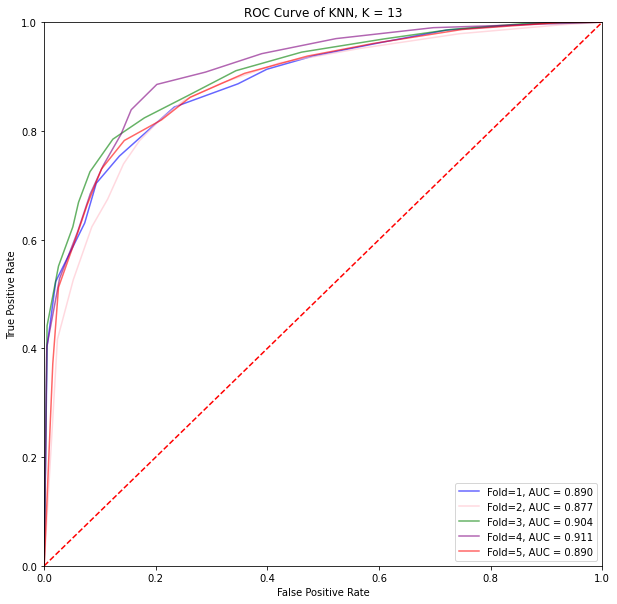

Average_AUC = 0.894


In [106]:
#Redo the continuous prediction with best K value and draw the roc-curve.
fold=0
sum_auc=0
colors=["blue","pink","green","purple","red"]
plt.figure(figsize=(10,10))
for train_index,test_index in kf.split(x):
        clf=KNeighborsClassifier(n_neighbors=best_k)
        clf.fit(S_train_x[train_index],S_train_y[train_index])
        if fold==0:
            #Show the first confusion matrix(classification)
            y_pred = clf.predict(x[test_index])
            print(confusion_matrix(y[test_index]-1, y_pred-1))
            print(classification_report(y[test_index]-1, y_pred-1))
        y_pred = clf.predict_proba(x[test_index])
        fpr, tpr, threshold = roc_curve(y[test_index]-1, y_pred[:,-1]-1)
        roc_auc = auc(fpr, tpr)
        sum_auc+=roc_auc
        plt.plot(fpr, tpr, color=colors[fold], label = 'Fold='+str(fold+1)+', AUC = %0.3f' % roc_auc,alpha=0.6)
        fold+=1
plt.legend(loc = 'lower right')
#Add the diagonal
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
title='ROC Curve of KNN, K = '+str(best_k)
plt.title(title)
plt.show()
#Show the average AUC
print("Average_AUC = %0.3f"%(sum_auc/5))

In [10]:
cross_val_score(KNeighborsClassifier(n_neighbors=best_k), S_train_x, S_train_y, cv=5)

array([0.82934363, 0.83320463, 0.85085008, 0.82921175, 0.8431221 ])

In [11]:
model=KNeighborsClassifier(n_neighbors=best_k)
model.fit(S_train_x, S_train_y)
y_pred=model.predict(test_x)
print(confusion_matrix(test_y, y_pred))
#print classification report
print(classification_report(test_y, y_pred))

[[158  38]
 [215 602]]
              precision    recall  f1-score   support

           1       0.42      0.81      0.56       196
           2       0.94      0.74      0.83       817

    accuracy                           0.75      1013
   macro avg       0.68      0.77      0.69      1013
weighted avg       0.84      0.75      0.77      1013



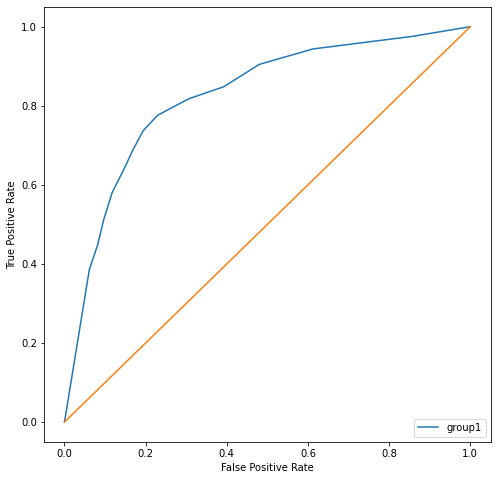

In [19]:
fig, ax=plt.subplots(figsize=(8,8))
model=KNeighborsClassifier(best_k)
model.fit(S_train_x, S_train_y)
plot_roc_curve(model, test_x, test_y, ax=ax, label="group1")
plt.plot([0,1],[0,1])
plt.show()